# Initial exploration of Quora dataset

The purpose of this notebook is to get the first contact with Quora dataset. Trying to answer the following questions
1. What kind of data we have?
2. What kind of problem? Examples from duplicate and non duplicate questions
3. How clean is the data?
    3.1 Missing data?
    3.2 Duplicate pair of questions?
        3.2.1 Have the duplicates pairs the same label?
        3.2.2 Have duplicate questions have the same id in different pair of questions?
    3.3 Outliers, noise?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.covariance import EllipticEnvelope

%matplotlib inline

In [2]:
# Load data
input_dir = '../input/'
train = pd.read_csv(input_dir  + 'train.csv')
test  = pd.read_csv(input_dir  + 'test.csv')

In [3]:
# First, get a look of the data we have
print("Number of train observations are %d"%train.shape[0])
print("Number of test observations are %d"%test.shape[0])
train.head()

Number of train observations are 404290
Number of test observations are 2345796


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Look at what kind of questions are considered duplicates (semantic, pure repetition, synonims, etc.) and which ones
# are considered non duplicates
def showof(df, showof, label):
    selected_label_df = train[train['is_duplicate']==label]
    for i in range(0,showof):
        print('Example: %d'%i)
        print('Q1: ' + selected_label_df.iloc[i].question1)
        print('Q2: ' + selected_label_df.iloc[i].question2)
        print('\n')


rows = 10
print('**** Showing the first %d pairs of repetead questions: ****\n'%rows)
showof(train, rows, 1)

print('**** Showing the first %d pairs of NON repetead questions: ****\n '%rows)
showof(train, rows, 0)

# Conclusion: Seems to be cases from all types exposed above, semantic ones, pure repetition and synonims. The problem
# is more complicated than it seems initially, some non duplicate questions are very tricky.

**** Showing the first 10 pairs of repetead questions: ****

Example: 0
Q1: Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Q2: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


Example: 1
Q1: How can I be a good geologist?
Q2: What should I do to be a great geologist?


Example: 2
Q1: How do I read and find my YouTube comments?
Q2: How can I see all my Youtube comments?


Example: 3
Q1: What can make Physics easy to learn?
Q2: How can you make physics easy to learn?


Example: 4
Q1: What was your first sexual experience like?
Q2: What was your first sexual experience?


Example: 5
Q1: What would a Trump presidency mean for current international master’s students on an F1 visa?
Q2: How will a Trump presidency affect the students presently in US or planning to study in US?


Example: 6
Q1: What does manipulation mean?
Q2: What does manipulation means?


Example: 7
Q1: Why are so many Quora users posting qu

## How clean is de data

In [5]:
# missing data
print("Missing data (none) per column")
print(train.isnull().sum(axis=0))


train["question1"] = train["question1"].apply(lambda x: str(x).strip()) 
train["question2"] = train["question2"].apply(lambda x: str(x).strip())
print("Number of empty string questions is %d"%((train.question1=="").sum() + (train.question2=="").sum()))

Missing data (none) per column
id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64
Number of empty string questions is 0


In [61]:
# Duplicated questions across pairs with different quid
def get_bad_duplicates(df, column1, column2):
    duplicated_column1 = df.duplicated(subset=column1, keep=False)
    duplicated_column2 = df.duplicated(subset=column2, keep=False)
    return duplicated_column1 & ~duplicated_column2

def show_bad_duplicates(df, column1, column2):
    bad_duplicates = get_bad_duplicates(df, column1, column2)
    print("The number of "+str(column1)+" duplicates with different "+str(column2)+" is:%d"%bad_duplicates.sum())
    if (bad_duplicates.sum() > 0):
        display(df[bad_duplicates].sort_values(by=column1).head(10))


to_test = [('qid1', 'question1'), ('qid2', 'question2')]
for pair in to_test:
    show_bad_duplicates(train, pair[0], pair[1])
    show_bad_duplicates(train, pair[1], pair[0])
    
# Seems that there are duplicate questions with different id but there are not any questions with 
# same id and different content

The number of qid1 duplicates with different question1 is:0
The number of question1 duplicates with different qid1 is:259


,id,qid1,qid2,question1,question2,is_duplicate
402423,402423,535899,119568,?,What is cisco router technical support phone n...,0
20794,20794,39204,39205,?,What is the Gmail tech support help phone number?,0
104101,104101,171925,171926,?,"Problem of solving a problem is not a problem,...",0
208485,208485,312495,312496,?,"Given that PACER makes money from usage, why d...",0
273065,273065,391451,380455,?,"How can I describe Quora, in all its glory, to...",0
36829,36829,42085,67114,? to be deleted,Why does everyone assume that America is the o...,0
119460,119460,193956,193957,Are we the fallen angels?,What are all the names of the fallen angels?,0
161551,161551,251717,251718,Are we the fallen angels?,If it is possible that there are fallen angels...,0
87181,87181,146875,122703,Are you happy with your life?,Are you happy with your life for the most part...,0
112729,112729,184402,122702,Are you happy with your life?,Are you really happy with your life?,1


The number of qid2 duplicates with different question2 is:0
The number of question2 duplicates with different qid2 is:230


,id,qid1,qid2,question1,question2,is_duplicate
269194,269194,386863,386864,What is the eligibility criteria for RBI GRADE...,Am I eligible for RBI Grade B exam?,0
145000,145000,229359,229360,Me and my girlfriend wish to go out and do 'st...,Deleted.,0
322261,322261,448056,147899,Am I cursed with bad luck?,Deleted.,0
65082,65082,70292,112999,Do you believe in ghosts? Why or why not?,Do you believe in ghosts?,1
220517,220517,327627,327628,Does he like me ?,Does he like me?,0
282604,282604,402566,402567,Who does he like?,Does he like me?,0
248256,248256,361645,361646,Does it mean that when a adult walks on their ...,Does it mean that when a adult walks on their ...,1
61963,61963,108094,108095,What medical problem is the 'three-parent baby...,Does it mean that when a adult walks on their ...,0
132155,132155,211701,211702,Has witchcraft been scientifically tested?,Have Mythical Creatures been scientifically te...,0
109009,109009,178981,178982,How do I make a box that I can put my phone in...,Hh,0


In [62]:
# Duplicated pair questions 
duplicated = train.duplicated(subset=['question1', 'question2'], keep=False)
print("Number of duplicated pair questions is %d"%duplicated.sum())
display(train[duplicated].sort_values(by=['qid1','qid2']))

# Duplicated pair questions with different labels
show_bad_duplicates(train, ['question1', 'question2'], ['question1', 'question2', 'is_duplicate'])

Number of duplicated pair questions is 10


,id,qid1,qid2,question1,question2,is_duplicate
341387,341387,74460,94926,What is the most beautiful moment in your life?,What was the most beautiful moment in your life?,1
250147,250147,162198,94926,What is the most beautiful moment in your life?,What was the most beautiful moment in your life?,1
109009,109009,178981,178982,How do I make a box that I can put my phone in...,Hh,0
289307,289307,178981,269923,How do I make a box that I can put my phone in...,Hh,0
220219,220219,187607,61930,Is the Indian media the worst compared to othe...,Is Indian media worst in the world?,1
115004,115004,187607,187608,Is the Indian media the worst compared to othe...,Is Indian media worst in the world?,1
123781,123781,200037,61930,Is Indian journalism (main stream media) worst...,Is Indian media worst in the world?,1
186587,186587,200037,187608,Is Indian journalism (main stream media) worst...,Is Indian media worst in the world?,1
244386,244386,288991,36624,What does my birth chart say about me ?,What does my birth chart say about me?,0
190035,190035,288991,39099,What does my birth chart say about me ?,What does my birth chart say about me?,0


The number of ['question1', 'question2'] duplicates with different ['question1', 'question2', 'is_duplicate'] is:0


In [65]:
# Outliers

# Number of characters
train["len_question1"] = train["question1"].apply(lambda x: len(x))
train["len_question2"] = train["question2"].apply(lambda x: len(x))
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,len_question1,len_question2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39


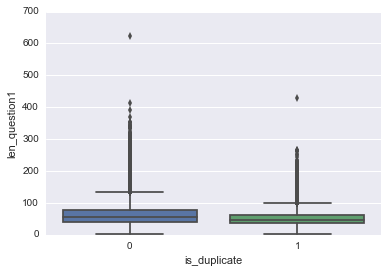

In [78]:
ax = plt.axes()
sns.boxplot(x='is_duplicate',y='len_question1', data=train, ax=ax)
plt.show()

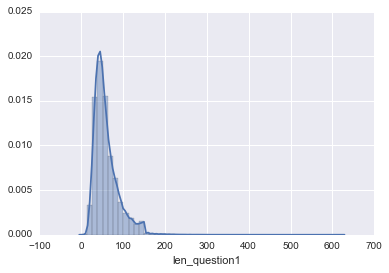

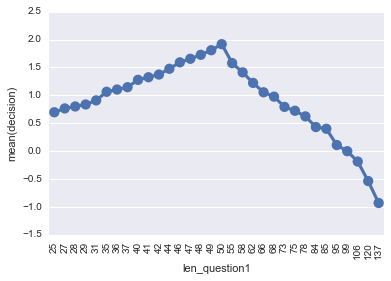

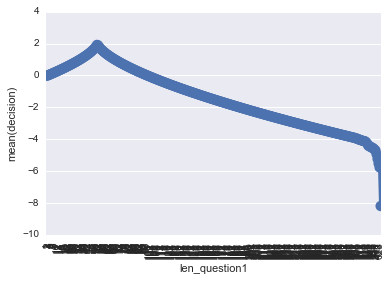

In [156]:
ax = plt.axes()
sns.distplot(train.len_question1, ax=ax)
plt.show()

clf = EllipticEnvelope()
clf.fit(np.transpose([train.len_question1]))
outliers = clf.predict(np.transpose([train.len_question1]))
decision = clf.decision_function(np.transpose([train.len_question1]))
ax = plt.axes()
train["decision"] = decision

sns.pointplot("len_question1", "decision",data=train.sample(frac=0.0001), ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

ax = plt.axes()
sns.pointplot("len_question1", "decision",data=train.sort_values(by="len_question1"), ax=ax)
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [9]:
print((decision>0).sum())
train[decision<0].sort_values(by='len_question1', ascending=True).head()

ax = plt.axes()
sns.distplot(train[decision>0].len_question1, ax=ax)
plt.show()

ax = plt.axes()
sns.distplot(train[decision<0].len_question1, ax=ax)
plt.show()

print(train[train.len_question1<10].shape)
train[train.len_question1<10].question1.value_counts().sort_values(ascending=False)

NameError: name 'decision' is not defined

In [77]:
outliers = train[train["len_question1"]>300]
for i in range(0,outliers.shape[0]):
    print('Outlier: %d'%i)
    print(outliers.iloc[i].question1)
    print('\n')


Outlier: 0
How often should I massage my face with Argan oil? Apparently, Argan oil is extremely beneficial for acne scars, healthy/radiant skins and etc. How often should I massage it onto my face before going to bed? Could I maybe use Argan oil one night and then the Liz Earle repair moisturiser the next to achieve a healthy, young and radiant skin? Plz help with answering :).


Outlier: 1
I have been using my girlfriend for a sexual relationship for the last year. She loves me more than anyone else ever has, and she would do anything for me. The thing is, I now have feelings for her, and I love her more than I could ever love anyone else. Do you think I should confess to her that earlier in our relationship I was only using her for sex?


Outlier: 2
I have a laptop with 4gb RAM, AMD A8-6410 APU with AMD Radeon R5 Graphics and Radeon R5-M230 2.5gb vram, will I be able to play assassins creed syndicate with these requirements? And I am able to play gta 5 in medium settings with no lag